In [7]:
import tempfile
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox
import os
import numpy as np

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, MaxPool1D, MaxPool2D, MaxPool3D
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
import tensorflow_docs as tfdocs
import time
import pickle
import tensorflow_addons as tfa


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Join = os.path.join
TEST_PROPORTION = 0.3
N_BACS = 16
ROOT = 'D:\\TCC'
DATASTORE = Join(ROOT, 'Datasets\\preprocess_bac_new')
MODELS_PATH_V4_150 = os.path.join(ROOT, 'models_v4_150')
MODELS_PATH_V4_170 = os.path.join(ROOT, 'models_v4_170')
MODELS_PATH_V4_241 = os.path.join(ROOT, 'models_v4_241')
LABELS = ['Bacillusscereus', 'Bacillussubtilis', 'Coryniumbacteriumlutaminum',
          'Enterobactearerogenes', 'Enterobactercloacal', 'Enterococcusfaecalis', 'Escheriachiacoli',
          'Klesbsialapneumonial', 'Micrococcusluteus', 'Proteusmirabilis', 'Pseudomonasaeoruginosas', 'Salmonellaspp',
          'Serratiamarcences', 'Staphylococcusaureus_6538', 'Staphylococcusaureus_25923', 'Staphylococcusepidemides']
METRICS_PATH_V4_150 = Join(ROOT, 'metrics_v4_150spc')
METRICS_PATH_V4_170 = Join(ROOT, 'metrics_v4_170spc')
METRICS_PATH_V4_241 = Join(ROOT,'metrics_v4_241spc')
MLP_241 = Join(METRICS_PATH_V4_241, 'mlp')
MLP_170 = Join(METRICS_PATH_V4_170, 'mlp')
MLP_150 = Join(METRICS_PATH_V4_150, 'mlp')
CNN_241 = Join(METRICS_PATH_V4_241, 'cnn')
CNN_170 = Join(METRICS_PATH_V4_170, 'cnn')
CNN_150 = Join(METRICS_PATH_V4_150, 'cnn')


Num GPUs Available:  1


In [8]:
COLORS = {
    'Bacillusscereus': np.array([255, 25, 0])/255.0,
    'Bacillussubtilis': np.array([194, 124, 81])/255.0,
    'Coryniumbacteriumlutaminum': np.array([125, 94, 32])/255.0,
    'Enterobactearerogenes': np.array([219, 207, 92])/255.0,
    'Enterobactercloacal': np.array([157, 176, 49])/255.0,
    'Enterococcusfaecalis': np.array([157, 255, 0])/255.0,
    'Escheriachiacoli': np.array([181, 138, 212])/255.0,
    'Klesbsialapneumonial': np.array([242, 0, 255])/255.0,
    'Micrococcusluteus': np.array([110, 150, 105])/255.0,
    'Proteusmirabilis': np.array([17, 82, 29])/255.0,
    'Pseudomonasaeoruginosas': np.array([133, 134, 140])/255.0,
    'Salmonellaspp': np.array([23, 230, 143])/255.0,
    'Serratiamarcences': np.array([74, 217, 217])/255.0,
    'Staphylococcusaureus_6538': np.array([26, 74, 176])/255.0,
    'Staphylococcusaureus_25923': np.array([145, 23, 207])/255.0,
    'Staphylococcusepidemides': np.array([191, 50, 75])/255.0,
}

In [9]:
def load_img_data(path,indx=None, filename='masked.pickle'):
    bacs = []
    dirs = os.listdir(path)
    if indx != None:
        dirs = np.array(dirs)[indx]
    for i in dirs:
        dirpath = os.path.join(path, i)
        files = os.listdir(dirpath)
        for j in files:
            if j == filename:
                pickle_in = open(os.path.join(dirpath, j), "rb")
                bacs.append(pickle.load(pickle_in))
    return bacs

def get_layer(hsi, layer):
    return hsi[:, :, layer]

def show_img_on_wave(cube, layer):
    mat = get_layer(cube, layer)
    plt.imshow(mat, cmap='gray')
    plt.show()


def hsi2mat(arr):
    if len(arr.shape) != 3:
        raise BaseException('A entrada deve possuir 3 dimensões')

    r, c, w = arr.shape
    return np.reshape(arr, (r*c, w))


def mat2hsi(mat, shape):
    return np.reshape(mat, shape)

def remove_blank_lines(bacs):
    new_bacs = []
    for i in bacs:
        bac = hsi2mat(i)
        new_bac = bac[~np.all(bac == 0, axis=1)]
        new_bacs.append(new_bac)
    return new_bacs

def remove_blank_lines_for_one_bac(bac):
    return bac[~np.all(bac == 0, axis=1)]

def create_dataset_labels(bacs):
    dataset = []
    for ind, val in enumerate(bacs):
        dataset.append([val, ind])
    return dataset

def concat_lines_on_datasets(x,y, bac, cl: int):
    if (x.shape[0] > 0):
      x = np.concatenate((x, bac))
    else:
      x = bac

    y = np.append(y, [cl]*len(bac))
    return (x, y)

def create_one_hot_encoding(dataset, nbacs):
  y = np.zeros((dataset.shape[0], nbacs))
  for i in range(len(dataset)):
    y[i,int(dataset[i])] = 1
  return y

def shuffle_dataset(x, y):
    seed = np.random.randint(0, 1000*1000)
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)
    return (x,y)

def split_xy(dataset):
    x = np.array([])
    y = np.array([], dtype=np.uint8)
    for f, l in dataset:
        x,y = concat_lines_on_datasets(x, y, f, l)
    return (x,y)
    # return (x, create_one_hot_encoding(y, N_BACS))


def split_xy(dataset, percentage):
    x1 = np.array([])
    y1 = np.array([], dtype=np.uint8)
    x2 = np.array([])
    y2 = np.array([], dtype=np.uint8)
    for bac, index in dataset:
        half = int(bac.shape[0]*percentage)
        x1, y1 = concat_lines_on_datasets(x1, y1, bac[:half,:], index)
        x2, y2 = concat_lines_on_datasets(x2, y2, bac[half:, :], index)
    return (x1,y1,x2,y2)

def load_dataset(path, filename):
    bacs = load_img_data(path, filename)
    #nozeros = remove_blank_lines(bacs)
    return create_dataset_labels(bacs)

def normalize(data):
    return tf.keras.utils.normalize(data, 1)


def normalize_cube(cube):
    mat = hsi2mat(cube)
    mat = normalize(mat)
    return mat2hsi(mat, cube.shape)

# execution
def cmatrix(labels, predict):
    cm = confusion_matrix(labels, predict)
    cm2 = cm / np.sum(cm, axis=1)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.arange(N_BACS))

    fig, ax = plt.subplots(figsize=(20, 20))
    cmp.plot(ax=ax, values_format='d')


def class_report(labels, predict):
    classfic = classification_report(
        labels, predict, np.arange(N_BACS), LABELS)
    print(classfic)


def show_img_on_wave(cube, layer):
    mat = get_layer(cube, layer)
    plt.imshow(mat, cmap='gray')
    plt.show()


def load_pickle(filename, dirpath):
    path = os.path.join(dirpath, filename)
    pickle_in = open(path, "rb")
    return pickle.load(pickle_in)


def get_cube_by_index(path, index, filename):
    bac = os.listdir(path)[index]
    bac_dir = os.path.join(path, bac)
    return load_pickle(filename, bac_dir)


def get_dir_name(path, index):
    return os.listdir(path)[index]

def plot_confusion_matrix(cm,
                          target_names,
                          customText=None,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          saveDir = None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f} {}'.format(accuracy, misclass, customText))
    if saveDir is not None:
        plt.savefig(Join(saveDir, 'cm'))
    plt.show()


def predict_on_bac(model, bac_mat):
    ypred = model.predict(bac_mat, batch_size=1800)
    return np.argmax(ypred, axis=1)

def plot_inference(img, predict, name, saveDir=None):
    I = np.dstack([img, img, img])
    rows, cols = img.shape
    pred_count = 0
    counter = 0

    for r in range(rows):
        for c in range(cols): 
            if img[r,c] != 0:
                I[r,c, :] = COLORS[LABELS[predict[pred_count]]]
                pred_count += 1

    fig, ax = plt.subplots()
    fig.set_size_inches(8,8)
    ax.set_title(name)
    for i in range(16):
        ax.plot(COLORS[LABELS[i]], label=LABELS[i],
                linewidth=10, color=COLORS[LABELS[i]])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.imshow(I, cmap=ListedColormap(COLORS.values()))
    if saveDir!=None:
        plt.savefig(saveDir, bbox_inches=Bbox.from_extents(0, 0, 10, 8))

def get_callbacks(tensorDir=None, name=None):
    cc = []
    cc.append(tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20))
    if tensorDir is not None:
        cc.append(TensorBoard(log_dir='{}/{}'.format(tensorDir, name)))
    return cc


def mlp_compile_and_fit(samples: tuple, layers: tuple,act='relu', tensorBoardDir=None, savePath=None, showSummary=False):
    assert samples is not None and layers is not None
    xtrain, ytrain, xtest, ytest = samples

    n_features = xtrain.shape[1]
    model_name = 'mlp'
    mlp_model = Sequential([
        Flatten(input_shape=(n_features, 1)),
    ])
    for i in layers:
        model_name += '-{}d-{}'.format(i, act)
        mlp_model.add(Dense(i, activation=act))

    NAME = '{}-{}'.format(model_name,
        int(time.time()))

    mlp_model.add(Dense(N_BACS, activation='softmax'))

    mlp_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy(name='scc')])
    if showSummary:
        mlp_model.summary()

    mlp_history = mlp_model.fit(xtrain, ytrain, batch_size=1500, epochs=1000, validation_data=(
        xtest, ytest), shuffle=True, callbacks=[get_callbacks(tensorBoardDir, NAME)])

    mlp_model.custom_name = model_name
    if savePath is not None:
        mlp_model.save(Join(savePath, model_name))
    return (mlp_model, mlp_history)


def cnn_compile_and_fit(samples: tuple, conv_layers: tuple, dense_layers: tuple, act_dense='relu',
                        between_layers: tuple = None, tensorDir=None, savePath=None, showSummary=False):

    assert samples is not None and conv_layers is not None and dense_layers is not None
    
    xtrain, ytrain, xtest, ytest = samples
    n_features = xtrain.shape[1]

    model_name = 'cnn'
    cnn_model = Sequential()
    for i in range(len(conv_layers)):
        fs, ks, ps = conv_layers[i]
        model_name += '-{}x{}x{}'.format(fs, ks, ps)
        if i == 0:
            cnn_model.add(Conv1D(filters=fs, kernel_size=ks, activation='relu',
                   input_shape=(n_features, 1)))
        else:
            cnn_model.add(Conv1D(filters=fs, kernel_size=ks, activation='relu'))
        
        if ps != -1:
            cnn_model.add(MaxPool1D(pool_size=ps))

        if between_layers is not None:
            for k in between_layers:
                cnn_model.add(k)
                
    cnn_model.add(Flatten())
    for i in dense_layers:
        model_name += '-{}d-{}'.format(i,act_dense)
        cnn_model.add(Dense(i, activation=act_dense))

    cnn_model.add(Dense(N_BACS, activation='softmax'))

    print(n_features, model_name)

    NAME = '{}-{}'.format(model_name,
        int(time.time()))

    cnn_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer='adam',
                    metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy(name='scc')])
    if showSummary:
        cnn_model.summary()

    cnn_history = cnn_model.fit(xtrain, ytrain, batch_size=1800, epochs=500, validation_data=(
        xtest, ytest), shuffle=True, callbacks=[get_callbacks(tensorDir, NAME)])

    cnn_model.custom_name = model_name
    if savePath is not None:
        cnn_model.save(Join(savePath, model_name))
    return (cnn_model, cnn_history)


def make_inf(model, path, isReduced=False):
    try:
        os.makedirs(path)
    except:
        print("Skipped - Directory already created!")

    metric_inference = Join(path, 'inference-{}')
    for i in range(N_BACS):
        test_path = Join(DATASTORE, 'Test')
        bac_cube = get_cube_by_index(test_path, i, 'masked.pickle')
        mat = hsi2mat(bac_cube)
        mat = remove_blank_lines_for_one_bac(mat)
        mat = mat - np.mean(mat)
        if isReduced:
            mat = remove_spectrum(mat, range(40, 210))

        classes = predict_on_bac(model, mat.reshape(mat.shape[0], mat.shape[1], 1))
        plot_inference(get_layer(bac_cube, 1), classes,
                    LABELS[i] + ' - {} espectros'.format(mat.shape[1]), metric_inference.format(LABELS[i]))

def metrify(xtest,ytest,model, labels,saveDir=None):
    if saveDir is not None:
        try:
            os.makedirs(saveDir)
        except:
            print("Skipped - Directory already created!")

    a,b,c = model.evaluate(xtest, ytest, batch_size=1500)
    ypred = model.predict(xtest, batch_size=1800, verbose=1)
    classes = np.argmax(ypred, axis=1)
    lab = np.array(ytest, dtype=np.uint8)
    cm = confusion_matrix(lab, classes)
    plot_confusion_matrix(
        cm, labels, 'loss: {:0.4f} scc: {:0.4f}'.format(a, c), saveDir=saveDir)
    classfic = classification_report(
        lab, classes, labels=np.arange(16), target_names=labels, digits=5)
    print(classfic)

def remove_spectrum(x, indx):
    return x[:,indx]


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    c2 = np.sum(np.round(np.clip(y_pred, 0, 1)))
    c3 = np.sum(np.round(np.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


In [10]:
indx = range(16)
labels = np.array(LABELS)[indx]


In [11]:
trainpath = Join(DATASTORE, 'Train')
dataset = load_img_data(trainpath, indx, 'mat_nobg.pickle')
bacs = create_dataset_labels(dataset)
x1, y1, x2, y2 = split_xy(bacs,0.5)


testpath = Join(DATASTORE, 'Test')
dataset = load_img_data(testpath, indx, 'mat_nobg.pickle')
bacs = create_dataset_labels(dataset)
k1, t1, k2, t2 = split_xy(bacs, 0.5)

xtrain = np.concatenate([x1, k1])
ytrain = np.concatenate([y1, t1])

xtest = np.concatenate([x2, k2])
ytest = np.concatenate([y2, t2])

xtrain = remove_spectrum(xtrain, range(40,210))
xtest = remove_spectrum(xtest, range(40, 210))

xtrain, ytrain = shuffle_dataset(xtrain,ytrain)
xtest, ytest = shuffle_dataset(xtest, ytest)

xtrain = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1)
xtest = xtest.reshape(xtest.shape[0],xtest.shape[1],1)

In [12]:
print(xtrain.shape, xtest.shape)
split = int(xtrain.shape[0] * 0.7)

(669414, 170, 1) (669431, 170, 1)


In [13]:
model_path = 'D:\\TCC\models_v4_170\\128x3x2_128x3x2_128d_128d'
model = tf.keras.models.load_model(model_path)
make_inf(model, model_path, True)


Skipped - Directory already created!


TypeError: an integer is required (got type range)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 166, 128)          768       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 83, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 384)           196992    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 384)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7296)              0

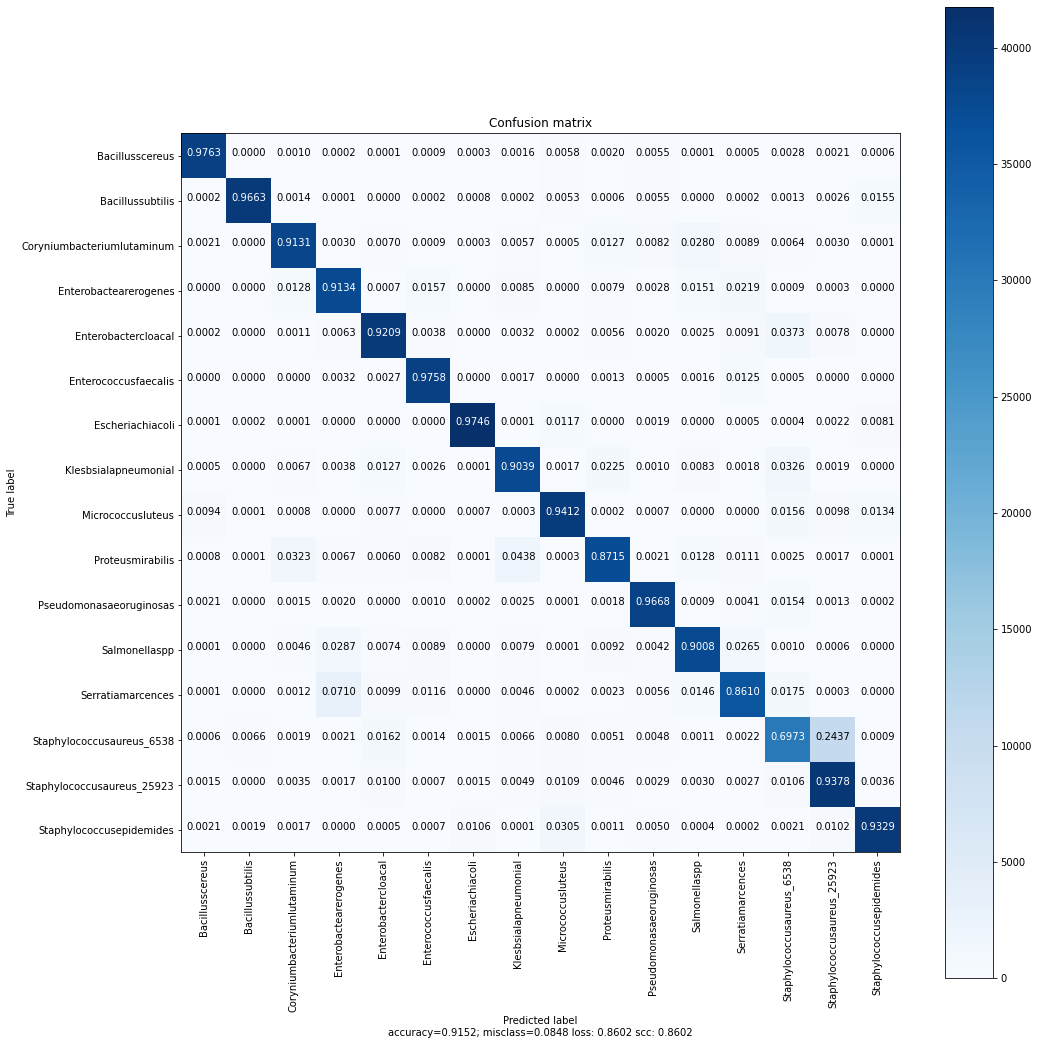

                            precision    recall  f1-score   support

           Bacillusscereus    0.97903   0.97629   0.97766     40023
          Bacillussubtilis    0.99030   0.96632   0.97816     41415
Coryniumbacteriumlutaminum    0.92807   0.91313   0.92054     41935
     Enterobactearerogenes    0.87439   0.91344   0.89349     40953
       Enterobactercloacal    0.92120   0.92086   0.92103     43390
      Enterococcusfaecalis    0.94300   0.97579   0.95911     40064
          Escheriachiacoli    0.98379   0.97462   0.97918     42830
      Klesbsialapneumonial    0.90688   0.90390   0.90539     41654
         Micrococcusluteus    0.92583   0.94118   0.93344     42400
          Proteusmirabilis    0.92019   0.87149   0.89518     42612
   Pseudomonasaeoruginosas    0.94617   0.96679   0.95637     40108
             Salmonellaspp    0.90996   0.90084   0.90538     41487
         Serratiamarcences    0.89390   0.86105   0.87717     41554
 Staphylococcusaureus_6538    0.82864   0.69729

In [7]:
n_features = xtrain.shape[1]
tensorDir = 'logs_v4'
savePath = MODELS_PATH_V4_170
model_name = '128x5x2_256x3x2_384x2x2_128d_128d'
NAME = '{}-{}'.format(model_name,
                      int(time.time()))
model = Sequential([
    Conv1D(128,5,activation='relu',input_shape=(n_features, 1)),
    MaxPool1D(pool_size=2),
    Conv1D(256, 3, activation='relu'),
    MaxPool1D(pool_size=2),
    Conv1D(384, 2, activation='relu'),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(indx), activation='softmax'),
])

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy(name='scc')])

history = model.fit(xtrain[:split, :], ytrain[:split], batch_size=1800, epochs=500, 
            validation_data=(xtrain[split:, :], ytrain[split:]), 
            shuffle=True, callbacks=[get_callbacks(tensorDir, NAME)])
metrify(xtest, ytest, model, labels)
model.save(Join(MODELS_PATH_V4_170, model_name))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 166, 128)          768       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 162, 128)          82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 81, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81, 128)           512       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 79, 256)           98560     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 77, 256)           196864    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 38, 256)          

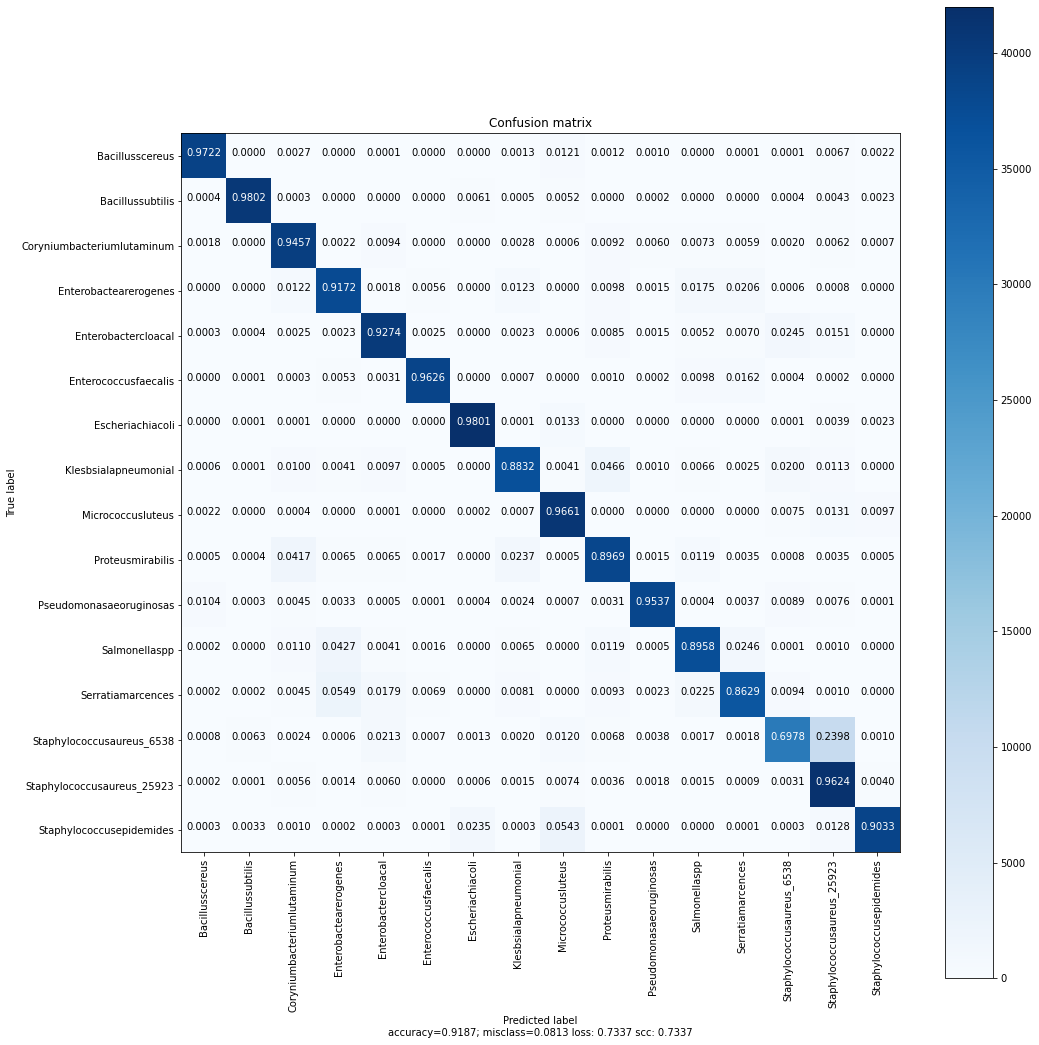

                            precision    recall  f1-score   support

           Bacillusscereus    0.98134   0.97224   0.97677     40023
          Bacillussubtilis    0.98807   0.98025   0.98415     41415
Coryniumbacteriumlutaminum    0.90492   0.94575   0.92489     41935
     Enterobactearerogenes    0.87977   0.91717   0.89808     40953
       Enterobactercloacal    0.92211   0.92745   0.92477     43390
      Enterococcusfaecalis    0.97901   0.96258   0.97073     40064
          Escheriachiacoli    0.96844   0.98008   0.97423     42830
      Klesbsialapneumonial    0.93104   0.88323   0.90650     41654
         Micrococcusluteus    0.89701   0.96608   0.93027     42400
          Proteusmirabilis    0.89170   0.89693   0.89431     42612
   Pseudomonasaeoruginosas    0.97731   0.95365   0.96534     40108
             Salmonellaspp    0.91363   0.89577   0.90462     41487
         Serratiamarcences    0.90903   0.86285   0.88534     41554
 Staphylococcusaureus_6538    0.90083   0.69778

In [8]:
n_features = xtrain.shape[1]
tensorDir = 'logs_v4'
savePath = MODELS_PATH_V4_170
model_name = '128x5x-1_128x5x2_bn_256x3x-1_256x3x2_bn_384x2x2_bn_128d_128d'
NAME = '{}-{}'.format(model_name,
                      int(time.time()))
model = Sequential([
    Conv1D(128, 5, activation='relu', input_shape=(n_features, 1)),
    Conv1D(128, 5, activation='relu'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Conv1D(256, 3, activation='relu'),
    Conv1D(256, 3, activation='relu'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Conv1D(384, 2, activation='relu'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(indx), activation='softmax'),
])

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy(name='scc')])

history = model.fit(xtrain[:split, :], ytrain[:split], batch_size=1800, epochs=500,
                    validation_data=(xtrain[split:, :], ytrain[split:]),
                    shuffle=True, callbacks=[get_callbacks(tensorDir, NAME)])
metrify(xtest, ytest, model, labels)
model.save(Join(MODELS_PATH_V4_170, model_name))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 166, 128)          768       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 160, 256)          229632    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 158, 256)          196864    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 79, 256)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 79, 256)           1024      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 75, 256)           327936    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 73, 256)          

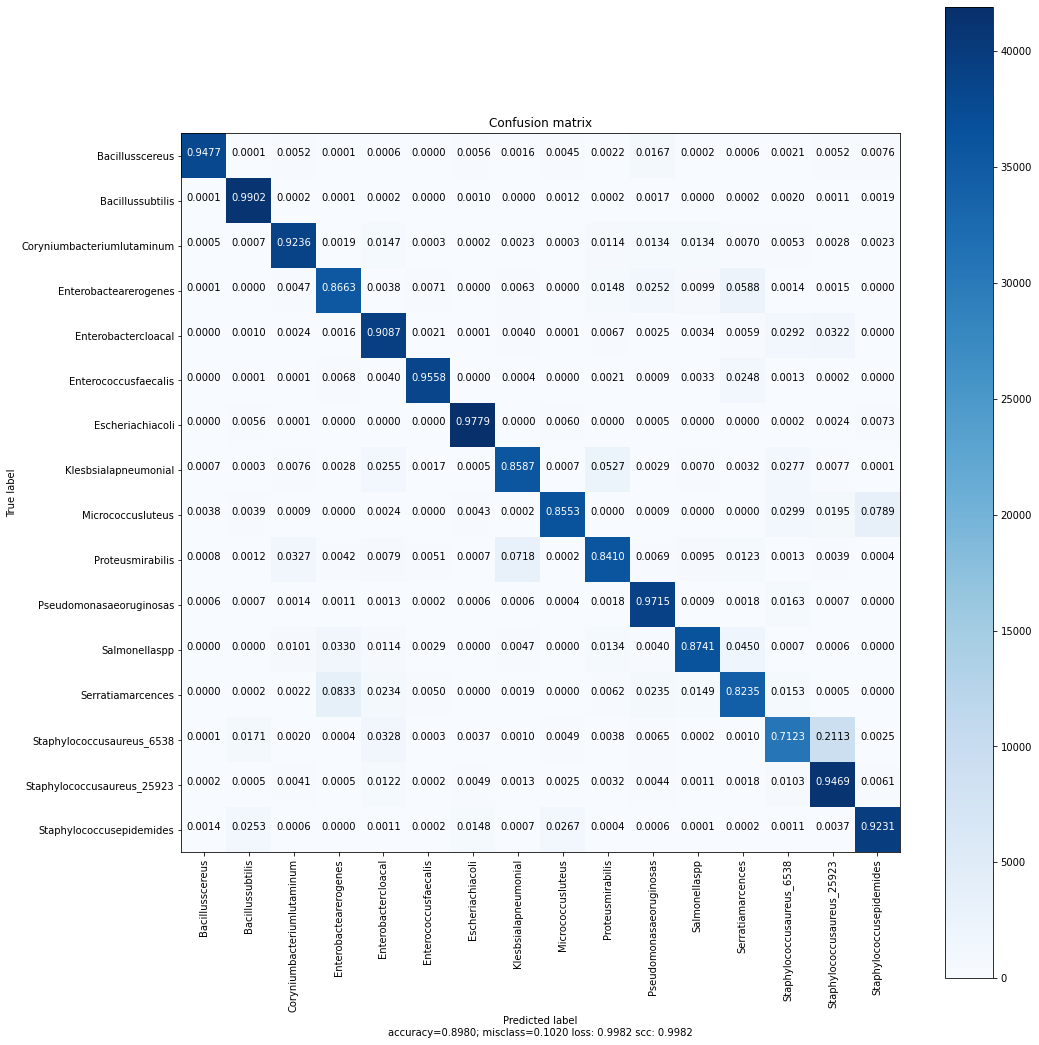

                            precision    recall  f1-score   support

           Bacillusscereus    0.99091   0.94766   0.96880     40023
          Bacillussubtilis    0.94419   0.99017   0.96663     41415
Coryniumbacteriumlutaminum    0.92527   0.92357   0.92442     41935
     Enterobactearerogenes    0.86275   0.86633   0.86454     40953
       Enterobactercloacal    0.86880   0.90869   0.88830     43390
      Enterococcusfaecalis    0.97319   0.95582   0.96443     40064
          Escheriachiacoli    0.96458   0.97791   0.97120     42830
      Klesbsialapneumonial    0.89708   0.85874   0.87749     41654
         Micrococcusluteus    0.94734   0.85528   0.89896     42400
          Proteusmirabilis    0.87840   0.84103   0.85931     42612
   Pseudomonasaeoruginosas    0.89461   0.97145   0.93145     40108
             Salmonellaspp    0.93133   0.87413   0.90182     41487
         Serratiamarcences    0.83600   0.82351   0.82971     41554
 Staphylococcusaureus_6538    0.83459   0.71228

In [9]:
n_features = xtrain.shape[1]
tensorDir = 'logs_v4'
savePath = MODELS_PATH_V4_170
model_name = '128x5x-1_256x7x-1_256x3x2_bn_256x5x-1_256x3x2_384x2x-1_384x1x2_bn_128d_128d'
NAME = '{}-{}'.format(model_name,
                      int(time.time()))
model = Sequential([
    Conv1D(128, 5, activation='relu', input_shape=(n_features, 1)),
    Conv1D(256, 7, activation='relu'),
    Conv1D(256, 3, activation='relu'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Conv1D(256, 5, activation='relu'),
    Conv1D(256, 3, activation='relu'),
    Conv1D(384, 2, activation='relu'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Conv1D(384, 2, activation='relu'),
    Conv1D(384, 1, activation='relu'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(indx), activation='softmax'),
])

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy(name='scc')])

xt = xtrain[:split, :]
yt = ytrain[:split]
xv = xtrain[split:, :]
yv = ytrain[split:]

history = model.fit(xt, yt, batch_size=1800, epochs=500,
                    validation_data=(xv, yv),
                    shuffle=True, callbacks=[get_callbacks(tensorDir, NAME)])
metrify(xtest, ytest, model, labels)
model.save(Join(MODELS_PATH_V4_170, model_name))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 168, 128)          512       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 84, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 82, 128)           49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 41, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5248)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               671872    
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

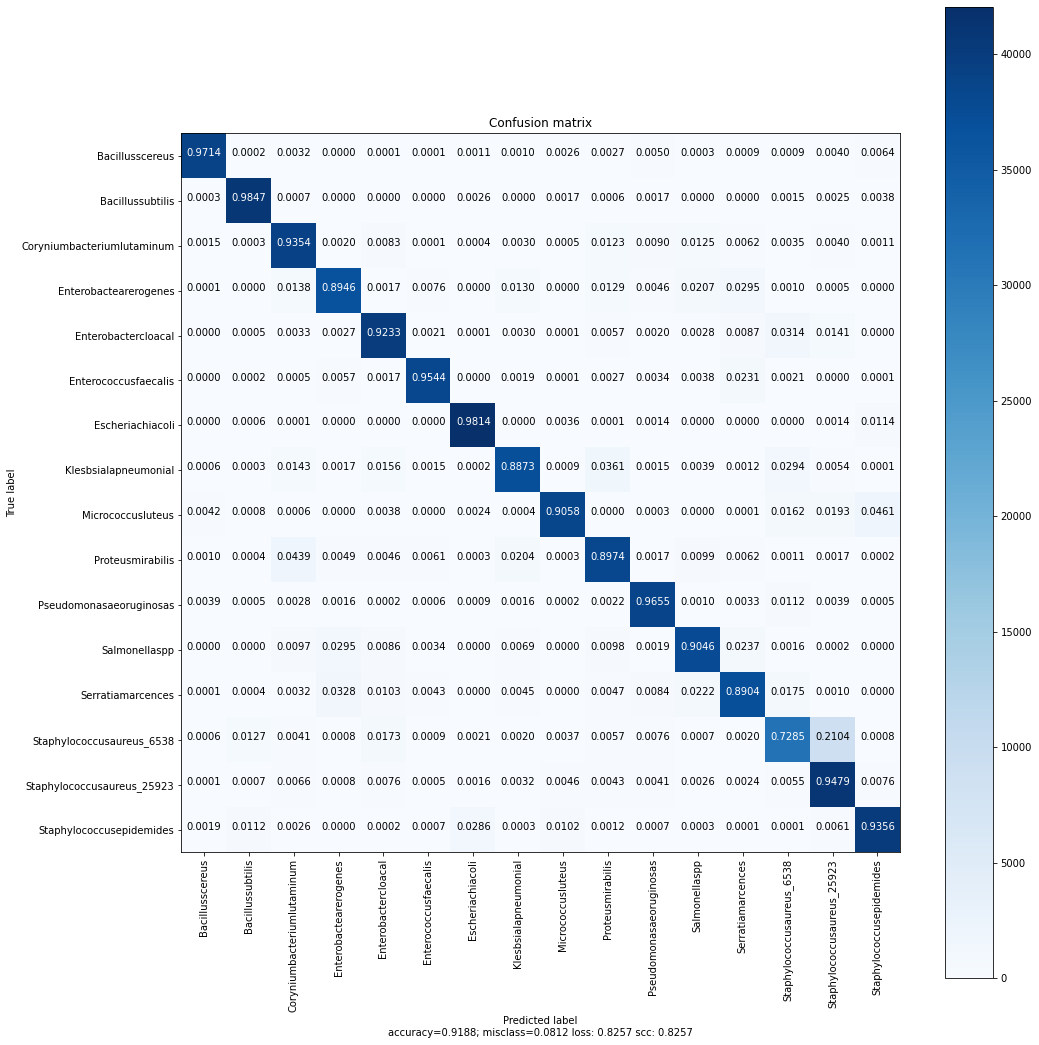

                            precision    recall  f1-score   support

           Bacillusscereus    0.98458   0.97139   0.97794     40023
          Bacillussubtilis    0.97061   0.98469   0.97760     41415
Coryniumbacteriumlutaminum    0.89510   0.93535   0.91478     41935
     Enterobactearerogenes    0.91428   0.89459   0.90432     40953
       Enterobactercloacal    0.92243   0.92332   0.92288     43390
      Enterococcusfaecalis    0.97041   0.95442   0.96235     40064
          Escheriachiacoli    0.96069   0.98141   0.97094     42830
      Klesbsialapneumonial    0.93532   0.88729   0.91067     41654
         Micrococcusluteus    0.96941   0.90575   0.93650     42400
          Proteusmirabilis    0.90070   0.89745   0.89907     42612
   Pseudomonasaeoruginosas    0.94543   0.96549   0.95536     40108
             Salmonellaspp    0.91770   0.90464   0.91112     41487
         Serratiamarcences    0.89301   0.89041   0.89171     41554
 Staphylococcusaureus_6538    0.85786   0.72852

In [10]:
n_features = xtrain.shape[1]
tensorDir = 'logs_v4'
savePath = MODELS_PATH_V4_170
model_name = '128x3x2_128x3x2_128d_128d'
NAME = '{}-{}'.format(model_name,
                      int(time.time()))
model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(n_features, 1)),
    MaxPool1D(pool_size=2),
    Conv1D(128, 3, activation='relu'),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(indx), activation='softmax'),
])

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy(name='scc')])

xt = xtrain[:split, :]
yt = ytrain[:split]
xv = xtrain[split:, :]
yv = ytrain[split:]

history = model.fit(xt, yt, batch_size=1800, epochs=500,
                    validation_data=(xv, yv),
                    shuffle=True, callbacks=[get_callbacks(tensorDir, NAME)])
metrify(xtest, ytest, model, labels)
model.save(Join(MODELS_PATH_V4_170, model_name))
